In [13]:
import os

import albumentations as A
import rich.progress as rprogress
import torch
from rich.traceback import install

from types import SimpleNamespace

from src.callbacks import ModelCheckpoint
from src.datasets import MultiDomainDataset, DomainRole, PreprocessingPipeline
from src.models import MLDG, BaseLearner, Encoder, Classifier

install(show_locals=False)

args = {
    "num_classes": 7,
    "batch_size": 16,
    "nonlinear_classifier": False,
    "dropout": 0.,
    "lr": 1e-5,
    "weight_decay": 0.,
}
args = SimpleNamespace(**args)


# Backend: albumentations
transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    ),
    A.ToTensorV2(),
])

augment_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3, p=0.5),
    A.ToGray(num_output_channels=3, p=0.10),
    A.Normalize(
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    ),
    A.ToTensorV2(),
])


def wrapper_albumentations_transform(transform: A.Compose):
    def transform_(img):
        img_ = img.permute(1, 2, 0).numpy()
        try:
            return transform(image=img_).get("image")
        except Exception as error:
            print(f"Failed to apply transform at image {img_.shape}, {img_.dtype}")
            raise error

    return transform_

pipeline = PreprocessingPipeline(
    source_transform=wrapper_albumentations_transform(augment_transform),
    target_transform=wrapper_albumentations_transform(transform),
)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device selected: {device}")

Device selected: cuda


In [3]:
domains = ["art_painting", "cartoon", "photo", "sketch"]
roles = [DomainRole.TARGET, DomainRole.TARGET, DomainRole.TARGET, DomainRole.TARGET]


In [16]:
def load_model(checkpoint, args):

    model = MLDG(
        network=BaseLearner(
            encoder=Encoder(hparams={}),
            classifier=Classifier(hparams={"num_feats": 2048, "num_classes": args.num_classes, "dropout": args.dropout})
        ),
        device=device,
        num_classes=args.num_classes,
        num_domains=len([role for role in roles if role == DomainRole.TARGET]),
        hparams={
            "num_meta_test": 1,
            "lr": args.lr,
            "weight_decay": args.weight_decay,
            "beta": args.beta,
            "lr_clone": args.lr,  # TODO: for now, using same value for both
            "weight_decay_clone": args.weight_decay,
        }
    )

    # Test
    model.load_state_dict(
        state_dict=torch.load(
            checkpoint
        )
    )
    model.eval()
    return model


In [17]:
dataset = MultiDomainDataset(
    root="../data/PACS/",
    domains=domains,
    roles=roles,
    transforms=[pipeline] * len(domains),
    seed=0,
    split_ratio=0.80,
)


progress_bar = rprogress.Progress(
    rprogress.SpinnerColumn(),
    *rprogress.Progress.get_default_columns(),
    rprogress.TimeElapsedColumn(),
    rprogress.TextColumn("{task.fields[metrics]}", justify="right"),
)

loaders = dataset.build_target_dataloaders(
    use_splits=False, batch_size=16, num_workers=8,
    shuffle=False, persistent_workers=True
)

In [18]:
RESULTS = {
    "BETAS": [0., 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0],
    "CHECKPOINTS": [
        "../dump/rare-violet-50.ckpt",
        "../dump/super-moon-51.ckpt",
        "../dump/revived-aardvark-52.ckpt",
        "../dump/glorious-monkey-53.ckpt",
        "../dump/deep-cherry-54.ckpt",
        "../dump/wise-valley-55.ckpt",
        "../dump/still-donkey-56.ckpt",
        "../dump/silvery-silence-57.ckpt",
        "../dump/treasured-dawn-58.ckpt",
        "../dump/rosy-disco-59.ckpt",
        "../dump/drawn-water-60.ckpt",
    ],
    "TEST_ACC": [],
}

In [19]:
for checkpoint in RESULTS["CHECKPOINTS"]:
    if not os.path.exists(checkpoint):
        print(f"Failed to locate checkpoint {checkpoint}")

In [20]:
args

namespace(num_classes=7,
          batch_size=16,
          nonlinear_classifier=False,
          dropout=0.0,
          lr=1e-05,
          weight_decay=0.0,
          beta=0.0)

In [21]:
with progress_bar:
    for BETA, CHECKPOINT in zip(RESULTS["BETAS"], RESULTS["CHECKPOINTS"]):
        args.beta = BETA
        model = load_model(CHECKPOINT, args)


        tasks = [
            progress_bar.add_task(
                description=f"Testing {dataset.domains[i]}",
                total=len(loader),
                metrics=f"acc: --",
            )
            for i, loader in enumerate(loaders)
        ]


        ACC = []
        for task, loader in zip(tasks, loaders):
            acc = 0
            count = 0
            for batch in loader:
                acc_ = model.log_metrics((batch,))

                count += 1
                acc += acc_

                progress_bar.update(
                    task,
                    advance=1,
                    metrics=f"acc: {acc_:.2%}",
                )

            acc /= count

            progress_bar.update(
                task,
                metrics=f"acc: {acc:.2%}",
            )
            ACC.append(acc)
        RESULTS["TEST_ACC"].append(ACC)

Output()

In [28]:
import matplotlib.pyplot as plt
import torch

def plot_test_accuracy_by_domain(data, domain_names=None):
    """
    Plots test accuracy as a function of beta for each domain, plus macro average line.

    Args:
        data (dict): {
            "BETAS": List[float],
            "TEST_ACC": List[List[torch.Tensor]]  # Outer list: per beta, inner list: per domain
        }
        domain_names (list of str, optional): Names of the domains. Defaults to ["P", "A", "C", "S"].
    """
    betas = data["BETAS"]
    test_acc = data["TEST_ACC"]

    if domain_names is None:
        domain_names = ["P", "A", "C", "S"]

    # Initialize accuracy lists per domain
    domain_acc = [[] for _ in domain_names]
    macro_avg = []

    for acc_list in test_acc:
        acc_values = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in acc_list]
        for i, acc in enumerate(acc_values):
            domain_acc[i].append(acc)
        macro_avg.append(sum(acc_values) / len(acc_values))

    # Plotting
    plt.figure(figsize=(8, 5))
    for i, accs in enumerate(domain_acc):
        plt.plot(betas, accs, label=domain_names[i], marker='o')

    # Plot macro average
    plt.plot(betas, macro_avg, label='Macro Avg', linestyle=':', color='black', linewidth=2)

    plt.grid()
    plt.xlabel("Beta")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Test Accuracy vs Beta per Domain")
    plt.legend()
    plt.tight_layout()
    plt.show()


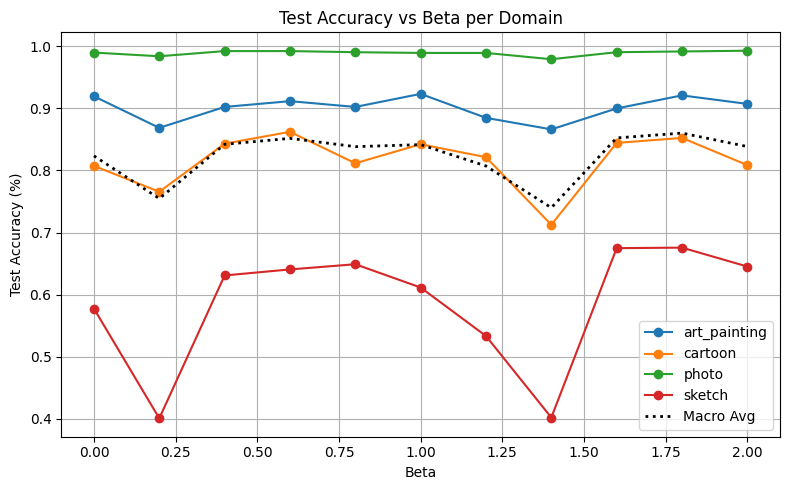

In [29]:
plot_test_accuracy_by_domain(
    RESULTS, domains
)

In [44]:
import matplotlib.pyplot as plt
import torch

def plot_test_accuracy_at_sketch(data, domain_names=None):
    """
    Plots test accuracy as a function of beta for each domain, plus macro average line.

    Args:
        data (dict): {
            "BETAS": List[float],
            "TEST_ACC": List[List[torch.Tensor]]  # Outer list: per beta, inner list: per domain
        }
        domain_names (list of str, optional): Names of the domains. Defaults to ["P", "A", "C", "S"].
    """
    betas = data["BETAS"]
    test_acc = data["TEST_ACC"]

    if domain_names is None:
        domain_names = ["P", "A", "C", "S"]

    # Initialize accuracy lists per domain
    domain_acc = [[] for _ in domain_names]
    macro_avg = []

    for acc_list in test_acc:
        acc_values = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in acc_list]
        for i, acc in enumerate(acc_values):
            domain_acc[i].append(acc)
        macro_avg.append(sum(acc_values) / len(acc_values))

    # Plotting
    plt.figure(figsize=(8, 5))
    for i, accs in enumerate(domain_acc):
        if i == 3:
            plt.bar(betas, accs, width=0.1, label=domain_names[i], align="center")

    # Plot macro average
    # plt.plot(betas, macro_avg, label='Macro Avg', linestyle=':', color='black', linewidth=2)

    plt.xlabel("Beta")
    plt.ylabel("Test Accuracy (%)")
    plt.xticks(betas)
    plt.title("Test Accuracy vs Beta per Domain")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"PACSBetaExperiment.png", dpi=1024, bbox_inches="tight", pad_inches=0.1, transparent=True)
    plt.show()


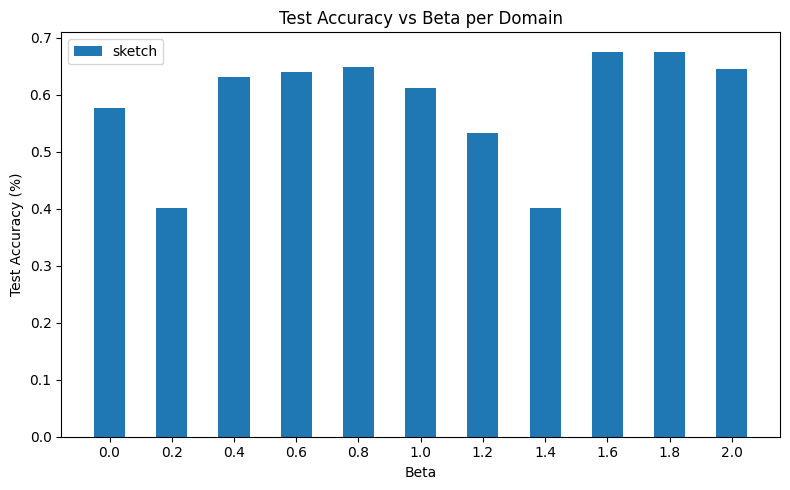

In [45]:
plot_test_accuracy_at_sketch(
    RESULTS, domains
)